D:\Application\anaconda3\envs\python_3.9\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
D:\Application\anaconda3\envs\python_3.9\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


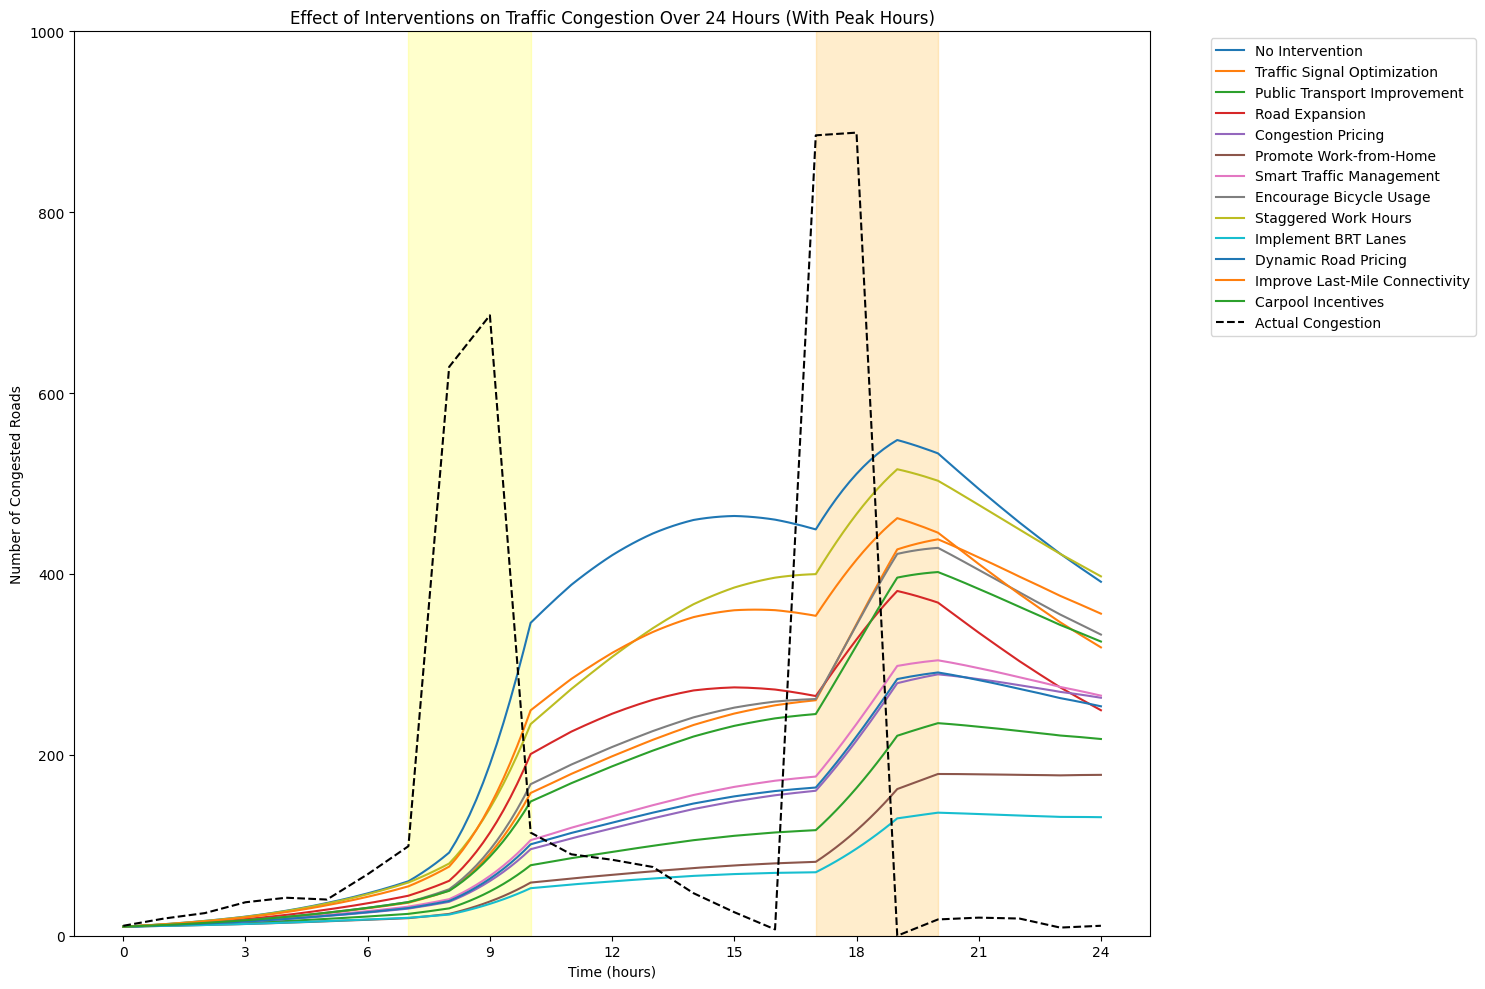

No Intervention: Average congestion = 29.51%, Peak congestion = 54.81%
Traffic Signal Optimization: Average congestion = 19.26%, Peak congestion = 43.83%
Public Transport Improvement: Average congestion = 10.05%, Peak congestion = 23.50%
Road Expansion: Average congestion = 18.65%, Peak congestion = 38.12%
Congestion Pricing: Average congestion = 12.67%, Peak congestion = 28.90%
Promote Work-from-Home: Average congestion = 7.60%, Peak congestion = 17.88%
Smart Traffic Management: Average congestion = 13.53%, Peak congestion = 30.45%
Encourage Bicycle Usage: Average congestion = 19.20%, Peak congestion = 42.89%
Staggered Work Hours: Average congestion = 25.70%, Peak congestion = 51.58%
Implement BRT Lanes: Average congestion = 6.25%, Peak congestion = 13.61%
Dynamic Road Pricing: Average congestion = 12.84%, Peak congestion = 29.11%
Improve Last-Mile Connectivity: Average congestion = 23.51%, Peak congestion = 46.17%
Carpool Incentives: Average congestion = 17.98%, Peak congestion = 40.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Main landmarks and commercial areas in Chengdu
LANDMARKS = {
    'Chunxi Road': (0, 0),
    'Taikoo Li': (0.5, 0.5),
    'Kuanzhai Alley': (-1, 1),
    'Du Fu Thatched Cottage': (-2, -1),
    'Jinli': (-1.5, -1.5),
    'Panda Base': (3, 2),
    'Tianfu Square': (0.2, -0.2),
    'Eastern Suburb Memory': (2.5, -1),
    'Chengdu Research Base of Giant Panda Breeding': (4, 3),
}

# Metro lines (simplified version)
METRO_LINES = [
    [('Chunxi Road', 'Taikoo Li'), ('Taikoo Li', 'Tianfu Square')],
    [('Kuanzhai Alley', 'Chunxi Road'), ('Chunxi Road', 'Eastern Suburb Memory')],
    [('Tianfu Square', 'Jinli'), ('Jinli', 'Du Fu Thatched Cottage')],
]
# Extended weather conditions and their impact
WEATHER_CONDITIONS = {
    'Sunny': 0,
    'Cloudy': 0.1,
    'Light Rain': 0.3,
    'Heavy Rain': 0.6,
    'Snow': 0.8,
    'Smog': 0.5,
    'Heatwave': 0.4,
    'Thunderstorm': 0.7
}

# Extended special events and their impact
SPECIAL_EVENTS = {
    'None': 0,
    'Spring Festival': 0.8,
    'Chengdu International Food Festival': 0.6,
    'Chengdu International Auto Show': 0.7,
    'Concert': 0.4,
    'Marathon': 0.5,
    'Traffic Accident': 0.7,
    'Major Sports Event': 0.6,
    'Political Rally': 0.5,
    'Street Market': 0.3
}

# New: Traffic light phases
TRAFFIC_LIGHT_PHASES = {
    'Normal': 1,
    'Rush Hour Optimized': 0.8,
    'Night Mode': 1.2,
    'Event Mode': 0.9
}

def calculate_population_density(pos, city_center=(0,0), base_density=20000):
    """
    Calculate population density based on distance from city center
    
    Parameters:
    pos: tuple of (x,y) coordinates
    city_center: tuple of city center coordinates
    base_density: maximum density at city center
    
    Returns:
    float: calculated population density
    """
    distance = np.sqrt((pos[0] - city_center[0])**2 + (pos[1] - city_center[1])**2)
    
    # 基本衰减模型：随距离指数衰减
    decay_rate = 0.3  # 控制衰减速度
    density = base_density * np.exp(-decay_rate * distance)
    
    # 添加随机变化以模拟现实中的密度波动
    # 使用对数正态分布来确保密度始终为正且有较大的变化范围
    random_factor = np.random.lognormal(mean=0.0, sigma=0.3)
    
    # 添加地铁站影响
    metro_boost = 0
    for name, pos_landmark in LANDMARKS.items():
        if 'Station' in name or name in ['Chunxi Road', 'Tianfu Square']:
            dist_to_landmark = np.sqrt((pos[0] - pos_landmark[0])**2 + (pos[1] - pos_landmark[1])**2)
            if dist_to_landmark < 1.0:  # 1km范围内
                metro_boost += 5000 * (1 - dist_to_landmark)  # 线性衰减的密度提升
    
    # 添加商业区影响
    commercial_boost = 0
    commercial_centers = {
        'Chunxi Road': 1.5,  # 权重因子
        'Taikoo Li': 1.3,
        'Tianfu Square': 1.4,
        'Eastern Suburb Memory': 1.1
    }
    for name, weight in commercial_centers.items():
        if name in LANDMARKS:
            dist_to_commercial = np.sqrt((pos[0] - LANDMARKS[name][0])**2 + (pos[1] - LANDMARKS[name][1])**2)
            if dist_to_commercial < 2.0:  # 2km范围内
                commercial_boost += 3000 * weight * (1 - dist_to_commercial/2)
    
    # 合并所有因素
    final_density = (density * random_factor + metro_boost + commercial_boost)
    
    # 确保密度在合理范围内
    return max(2000, min(final_density, 50000))

def generate_chengdu_road_network(n_rings=5, n_radial=12, n_secondary=50):
    G = nx.Graph()
    
    # 添加环路和放射状道路
    for r in range(1, n_rings + 1):
        for i in range(n_radial):
            angle = 2 * np.pi * i / n_radial
            x = r * np.cos(angle)
            y = r * np.sin(angle)
            pos = (x, y)
            G.add_node((r, i), pos=pos, 
                      population_density=calculate_population_density(pos))
            if i > 0:
                G.add_edge((r, i), (r, i-1))
        G.add_edge((r, n_radial-1), (r, 0))
    
    # 添加中心点（天府广场）
    center_pos = (0, 0)
    G.add_node((0, 0), pos=center_pos, 
               population_density=calculate_population_density(center_pos))
    
    # 连接环路
    for i in range(n_radial):
        for r in range(1, n_rings):
            G.add_edge((r, i), (r+1, i))
    
    # 添加地标
    for name, pos in LANDMARKS.items():
        G.add_node(name, pos=pos, 
                  population_density=calculate_population_density(pos))
        # 连接到最近的节点
        closest_node = min(G.nodes(), 
                         key=lambda n: np.linalg.norm(np.array(G.nodes[n]['pos']) - np.array(pos)) 
                         if 'pos' in G.nodes[n] else float('inf'))
        G.add_edge(name, closest_node)
    
    # 添加地铁线路
    for line in METRO_LINES:
        for start, end in line:
            if start in G.nodes() and end in G.nodes():
                G.add_edge(start, end, is_metro=True)
    
    return G

def generate_simulated_data(G, num_days=60):
    np.random.seed(42)
    data = []
    base_congestion = {edge: np.random.uniform(0.2, 0.8) for edge in G.edges()}
    
    # Define holidays
    holidays = set([0, 1, 2, 3, 4, 5, 6])  # Spring Festival
    holidays.update([30, 31, 32])  # Labor Day
    holidays.update([150, 151, 152])  # National Day
    
    for day in range(num_days):
        is_weekend = day % 7 >= 5
        is_holiday = day in holidays
        season = (day // 90) % 4
        
        daily_weather = np.random.choice(list(WEATHER_CONDITIONS.keys()), 
                                       p=[0.3, 0.2, 0.1, 0.05, 0.05, 0.1, 0.1, 0.1])
        daily_event = np.random.choice(list(SPECIAL_EVENTS.keys()), 
                                     p=[0.6, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.03, 0.02])
        
        for hour in range(24):
            # 确定信号灯配时方案
            if 7 <= hour < 10 or 17 <= hour < 20:
                light_phase = 'Rush Hour Optimized'
            elif 23 <= hour or hour < 5:
                light_phase = 'Night Mode'
            elif daily_event != 'None':
                light_phase = 'Event Mode'
            else:
                light_phase = 'Normal'
            
            for edge in G.edges():
                # 获取边两端节点的人口密度
                node1, node2 = edge
                pop_density1 = G.nodes[node1].get('population_density', 10000)
                pop_density2 = G.nodes[node2].get('population_density', 10000)
                
                # 使用两端节点的平均人口密度
                population_density = (pop_density1 + pop_density2) / 2
                
                # 根据人口密度调整道路容量和基础交通流量
                road_capacity = np.random.randint(500, 2000) * (1 + 0.2 * (population_density / 20000))
                base_traffic_volume = np.random.randint(100, int(road_capacity * 0.8)) * (population_density / 20000)
                
                is_peak_time = 1 if (hour in [8, 9, 17, 18]) else 0
                is_metro = G.edges[edge].get('is_metro', False)
                public_transit_usage = np.random.randint(0, 200) * (1.5 if is_metro else 1)
                num_poi = np.random.randint(0, 20)
                
                time_factor = 1 + 0.2 * np.sin(2 * np.pi * hour / 24)
                weather_factor = 1 + WEATHER_CONDITIONS[daily_weather] * np.random.uniform(0.5, 1.5)
                event_factor = 1 + SPECIAL_EVENTS[daily_event] * np.random.uniform(0.5, 1.5)
                weekend_factor = 1.2 if is_weekend else 1
                holiday_factor = 1.5 if is_holiday else 1
                season_factor = 1 + 0.1 * np.sin(2 * np.pi * season / 4)
                light_factor = TRAFFIC_LIGHT_PHASES[light_phase]
                
                # 计算最终交通流量，考虑人口密度影响
                traffic_volume = (
                    base_traffic_volume * 
                    time_factor * 
                    weather_factor * 
                    event_factor * 
                    weekend_factor * 
                    holiday_factor * 
                    season_factor *
                    light_factor
                )
                
                # 计算拥堵程度，考虑人口密度影响
                congestion_level = (
                    base_congestion[edge] +
                    0.3 * (traffic_volume / road_capacity) +
                    0.2 * is_peak_time +
                    0.01 * (population_density / 10000) -
                    0.05 * (public_transit_usage / 100) +
                    0.02 * (num_poi / 10) +
                    0.1 * WEATHER_CONDITIONS[daily_weather] +
                    0.1 * SPECIAL_EVENTS[daily_event] +
                    0.1 * (1 if is_weekend else 0) +
                    0.2 * (1 if is_holiday else 0) +
                    0.05 * np.sin(2 * np.pi * season / 4) +
                    0.1 * (1 - TRAFFIC_LIGHT_PHASES[light_phase]) +
                    np.random.normal(0, 0.05)
                )
                
                congestion_level = max(0, min(congestion_level, 1))
                
                data.append([
                    day, hour, edge, road_capacity, traffic_volume,
                    is_peak_time, public_transit_usage, population_density,
                    num_poi, daily_weather, daily_event, is_weekend, is_holiday,
                    season, is_metro, light_phase, congestion_level
                ])
    
    columns = [
        'day', 'hour', 'edge', 'road_capacity', 'traffic_volume',
        'is_peak_time', 'public_transit_usage', 'population_density',
        'num_poi', 'weather', 'special_event', 'is_weekend', 'is_holiday',
        'season', 'is_metro', 'traffic_light_phase', 'congestion_level'
    ]
    
    return pd.DataFrame(data, columns=columns)

def sir_traffic_model(y, t, N, base_beta, base_gamma, hourly_congestion, peak_factor=1.5, off_peak_factor=1.0):
    S, I, R = y
    hour = int(t) % 24
    current_congestion = hourly_congestion[hour]
    
    # 定义早高峰和晚高峰
    morning_peak = (7 <= hour < 10)
    evening_peak = (17 <= hour < 20)
    
    # 在高峰期调整beta和gamma
    if morning_peak or evening_peak:
        current_beta = base_beta * peak_factor * (1 + current_congestion)
        current_gamma = base_gamma / peak_factor / (1 + current_congestion)
    else:
        current_beta = base_beta * off_peak_factor * (1 + current_congestion)
        current_gamma = base_gamma / off_peak_factor / (1 + current_congestion)
    
    dSdt = -current_beta * S * I / N
    dIdt = current_beta * S * I / N - current_gamma * I
    dRdt = current_gamma * I
    return dSdt, dIdt, dRdt


def time_factor(hour):
    # Enhanced time factor to better model late night traffic decline
    if 0 <= hour < 5:  # Midnight to 5AM
        return 0.1 + 0.1 * np.sin(np.pi * hour / 10)
    elif 5 <= hour < 7:  # Early morning rise
        return 0.2 + 0.3 * ((hour - 5) / 2)
    elif 20 <= hour <= 24:  # Evening decline
        return max(0.1, 1.0 - 0.3 * (hour - 20))
    else:  # Regular daytime hours
        return 0.5 + 0.5 * np.sin(np.pi * (hour - 6) / 24)

def analyze_interventions(df):
    N = 1000  # 总道路数量
    
    # 计算每小时的平均拥堵程度
    hourly_congestion = df.groupby('hour')['congestion_level'].mean()
    hourly_congestion = (hourly_congestion - hourly_congestion.min()) / (hourly_congestion.max() - hourly_congestion.min())
    
    # 初始条件
    I0 = int(N * 0.01)  # 初始拥堵设置为1%
    R0 = 0
    S0 = N - I0 - R0
    
    t = np.linspace(0, 24, 145)  # 模拟一天，每10分钟一个数据点
    
    interventions = {
        'No Intervention': {'beta': 0.3, 'gamma': 0.1, 'peak_factor': 1.5, 'off_peak_factor': 1.0},
        'Traffic Signal Optimization': {'beta': 0.25, 'gamma': 0.12, 'peak_factor': 1.4, 'off_peak_factor': 1.0},
        'Public Transport Improvement': {'beta': 0.22, 'gamma': 0.15, 'peak_factor': 1.3, 'off_peak_factor': 1.0},
        'Road Expansion': {'beta': 0.28, 'gamma': 0.18, 'peak_factor': 1.4, 'off_peak_factor': 1.1},
        'Congestion Pricing': {'beta': 0.24, 'gamma': 0.14, 'peak_factor': 1.2, 'off_peak_factor': 1.0},
        'Promote Work-from-Home': {'beta': 0.20, 'gamma': 0.12, 'peak_factor': 1.3, 'off_peak_factor': 0.9},
        'Smart Traffic Management': {'beta': 0.23, 'gamma': 0.16, 'peak_factor': 1.3, 'off_peak_factor': 1.1},
        'Encourage Bicycle Usage': {'beta': 0.26, 'gamma': 0.13, 'peak_factor': 1.4, 'off_peak_factor': 1.0},
        'Staggered Work Hours': {'beta': 0.27, 'gamma': 0.11, 'peak_factor': 1.3, 'off_peak_factor': 1.1},
        'Implement BRT Lanes': {'beta': 0.21, 'gamma': 0.17, 'peak_factor': 1.2, 'off_peak_factor': 1.0},
        'Dynamic Road Pricing': {'beta': 0.25, 'gamma': 0.15, 'peak_factor': 1.2, 'off_peak_factor': 1.0},
        'Improve Last-Mile Connectivity': {'beta': 0.28, 'gamma': 0.14, 'peak_factor': 1.4, 'off_peak_factor': 1.1},
        'Carpool Incentives': {'beta': 0.26, 'gamma': 0.13, 'peak_factor': 1.3, 'off_peak_factor': 1.0},
    }
    
    plt.figure(figsize=(15, 10))
    
    for intervention, params in interventions.items():
        solution = odeint(sir_traffic_model, [S0, I0, R0], t, args=(N, params['beta'], params['gamma'], hourly_congestion, params['peak_factor'], params['off_peak_factor']))
        S, I, R = solution.T
        plt.plot(t, I, label=intervention)
    
    # 计算并绘制实际拥堵数据,考虑时间因子
    actual_congestion = [int(N * hourly_congestion[hour % 24] * time_factor(hour)) for hour in range(25)]
    plt.plot(range(25), actual_congestion, 'k--', label='Actual Congestion')
    
    plt.title('Effect of Interventions on Traffic Congestion Over 24 Hours (With Peak Hours)')
    plt.xlabel('Time (hours)')
    plt.ylabel('Number of Congested Roads')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(range(0, 25, 3))
    plt.ylim(0, N)
    
    # 标记早晚高峰时段
    plt.axvspan(7, 10, alpha=0.2, color='yellow', label='Morning Peak')
    plt.axvspan(17, 20, alpha=0.2, color='orange', label='Evening Peak')
#     plt.axvspan(31, 34, alpha=0.2, color='yellow')
    
    plt.tight_layout()
    plt.show()
#     plt.savefig('intervention_effects_on_congestion_daily_extended_factors1.png', dpi=300, bbox_inches='tight')
#     plt.close()

    # Calculate and print average congestion levels
    # 计算和打印平均拥堵水平
    results = []
    for intervention, params in interventions.items():
        solution = odeint(sir_traffic_model, [S0, I0, R0], t, args=(N, params['beta'], params['gamma'], hourly_congestion, params['peak_factor'], params['off_peak_factor']))
        _, I, _ = solution.T
        avg_congestion = np.mean(I) / N * 100
        peak_congestion = np.max(I) / N * 100
        results.append((intervention, avg_congestion, peak_congestion))
        print(f"{intervention}: Average congestion = {avg_congestion:.2f}%, Peak congestion = {peak_congestion:.2f}%")

    actual_avg_congestion = np.mean(actual_congestion) / N * 100
    actual_peak_congestion = np.max(actual_congestion) / N * 100
    print(f"Actual: Average congestion = {actual_avg_congestion:.2f}%, Peak congestion = {actual_peak_congestion:.2f}%")

    # 排序并打印最有效的措施
    results.sort(key=lambda x: x[1])  # 按平均拥堵程度排序
    print("\nMost effective interventions (by average congestion):")
    for i, (intervention, avg_congestion, _) in enumerate(results[:5], 1):
        print(f"{i}. {intervention}: {avg_congestion:.2f}%")

    results.sort(key=lambda x: x[2])  # 按峰值拥堵程度排序
    print("\nMost effective interventions (by peak congestion):")
    for i, (intervention, _, peak_congestion) in enumerate(results[:5], 1):
        print(f"{i}. {intervention}: {peak_congestion:.2f}%")

    # 计算每种干预措施的平均拥堵水平
    for intervention, params in interventions.items():
        solution = odeint(sir_traffic_model, [S0, I0, R0], t, args=(N, params['beta'], params['gamma'], hourly_congestion))
        _, I, _ = solution.T
        avg_congestion = np.mean(I) / N * 100
        print(f"{intervention}: Average congestion level = {avg_congestion:.2f}%")

    # 计算实际拥堵的平均水平
    actual_avg_congestion = np.mean(actual_congestion) / N * 100
    print(f"Actual: Average congestion level = {actual_avg_congestion:.2f}%")

def main():
    G = generate_chengdu_road_network()
    df = generate_simulated_data(G)
    analyze_interventions(df)

if __name__ == "__main__":
    main()